In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
import tensorflow as tf
np.random.seed(777)
tf.random.set_seed(777)

2025-12-08 21:38:33.216149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765229913.239176     147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765229913.246212     147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (87554, 188)
Test set shape: (21892, 188)


In [4]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print(f"\n📊 Data Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")


📊 Data Shapes:
   X_train: (87554, 187)
   y_train: (87554,)
   X_test: (21892, 187)
   y_test: (21892,)


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
# ------------------------------------------------------------------
# 2.1: Custom Dataset
# ------------------------------------------------------------------
class HeartbeatDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, 187), y: (N,)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Add channel dimension: (187,) -> (1, 187)
        x = self.X[idx].unsqueeze(0)    # (1, 187)
        y = self.y[idx]
        return x, y

# ------------------------------------------------------------------
# 2.2: Create datasets and loaders
# ------------------------------------------------------------------
train_dataset = HeartbeatDataset(X_train, y_train)
test_dataset  = HeartbeatDataset(X_test,  y_test)

batch_size = 256

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         drop_last=False)


In [7]:
# ------------------------------------------------------------------
# 3.1: Compute class weights from training labels
# ------------------------------------------------------------------
labels_np = y_train.astype(int)
class_counts = np.bincount(labels_np)  # length 5

print("Class counts:", class_counts)

# Inverse frequency
class_weights = 1.0 / (class_counts + 1e-8)

# Normalize a bit so weights are in a "reasonable" range
class_weights = class_weights * (len(class_counts) / class_weights.sum())

print("Raw class weights:", class_weights)

# Move to torch
class_weights_tensor = torch.tensor(class_weights,
                                    dtype=torch.float32).to(device)
print("Class weights tensor:", class_weights_tensor)


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


Class counts: [72471  2223  5788   641  6431]
Raw class weights: [0.02933416 0.95630948 0.36729025 3.31649917 0.33056694]
Class weights tensor: tensor([0.0293, 0.9563, 0.3673, 3.3165, 0.3306], device='cuda:0')


# Hybrid Model Definition

In [8]:

# CNN + LSTM hybrid model with Adaptive Average Pooling

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=5,
                 cnn_out_channels1=32,
                 cnn_out_channels2=64,
                 lstm_hidden_size=64,
                 lstm_num_layers=1,
                 dropout_p=0.5,
                 bidirectional=True):
        super(CNNLSTM, self).__init__()

        # 1D CNN feature extractor
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=cnn_out_channels1,
            kernel_size=5,
            padding=2  # same-ish length
        )
        self.bn1 = nn.BatchNorm1d(cnn_out_channels1)
        self.pool1 = nn.AdaptiveAvgPool1d(50)

        self.conv2 = nn.Conv1d(
            in_channels=cnn_out_channels1,
            out_channels=cnn_out_channels2,
            kernel_size=5,
            padding=2
        )
        self.bn2 = nn.BatchNorm1d(cnn_out_channels2)
        self.pool2 = nn.AdaptiveAvgPool1d(50)

        # LSTM for temporal modeling
        self.bidirectional = bidirectional
        self.lstm_hidden_size = lstm_hidden_size
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=cnn_out_channels2,   # features per time-step
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,               # (B, T, F)
            bidirectional=bidirectional
        )

        # Dropout & final classifier
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(
            lstm_hidden_size * self.num_directions,
            num_classes
        )

    def forward(self, x):
        """
        x: (B, 1, 187)
        """
        # ---- CNN part ----
        x = self.conv1(x)            # (B, 32, 187)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)            # (B, 32, ~93)

        x = self.conv2(x)            # (B, 64, ~93)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)            # (B, 64, ~46)

        # ---- Prepare for LSTM ----
        # LSTM wants (B, T, F), we currently have (B, C, L)
        x = x.permute(0, 2, 1)       # (B, ~46, 64)

        # ---- LSTM ----
        lstm_out, (h_n, c_n) = self.lstm(x)
        # h_n: (num_layers * num_directions, B, hidden_size)

        if self.bidirectional:
            # Last layer's forward and backward hidden states
            h_forward = h_n[-2, :, :]  # (B, hidden_size)
            h_backward = h_n[-1, :, :] # (B, hidden_size)
            h_cat = torch.cat((h_forward, h_backward), dim=1)  # (B, 2*hidden_size)
        else:
            h_cat = h_n[-1, :, :]     # (B, hidden_size)

        # ---- Classifier ----
        out = self.dropout(h_cat)
        out = self.fc(out)           # (B, num_classes)

        return out


In [9]:

model = CNNLSTM(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


CNNLSTM(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AdaptiveAvgPool1d(output_size=50)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AdaptiveAvgPool1d(output_size=50)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


# Training

In [10]:

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)  # (B, 1, 187)
        y_batch = y_batch.to(device)  # (B,)

        # Forward
        outputs = model(X_batch)      # (B, 5)
        loss = criterion(outputs, y_batch)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * y_batch.size(0)
        _, preds = torch.max(outputs, dim=1)
        running_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * y_batch.size(0)
            _, preds = torch.max(outputs, dim=1)
            running_correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total

    return epoch_loss, epoch_acc


In [11]:

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = evaluate(
        model, test_loader, criterion, device
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"| Test Loss: {val_loss:.4f} | Test Acc: {val_acc:.4f}"
    )


Epoch [1/20] Train Loss: 0.7117 | Train Acc: 0.6092 | Test Loss: 0.6210 | Test Acc: 0.7914
Epoch [2/20] Train Loss: 0.4341 | Train Acc: 0.7987 | Test Loss: 0.5505 | Test Acc: 0.7873
Epoch [3/20] Train Loss: 0.3825 | Train Acc: 0.8252 | Test Loss: 0.5324 | Test Acc: 0.8150
Epoch [4/20] Train Loss: 0.3454 | Train Acc: 0.8423 | Test Loss: 0.4534 | Test Acc: 0.8367
Epoch [5/20] Train Loss: 0.2980 | Train Acc: 0.8676 | Test Loss: 0.3666 | Test Acc: 0.8750
Epoch [6/20] Train Loss: 0.2793 | Train Acc: 0.8754 | Test Loss: 0.4007 | Test Acc: 0.8749
Epoch [7/20] Train Loss: 0.2585 | Train Acc: 0.8868 | Test Loss: 0.3643 | Test Acc: 0.8879
Epoch [8/20] Train Loss: 0.2428 | Train Acc: 0.8901 | Test Loss: 0.2856 | Test Acc: 0.9068
Epoch [9/20] Train Loss: 0.2372 | Train Acc: 0.8935 | Test Loss: 0.2139 | Test Acc: 0.9318
Epoch [10/20] Train Loss: 0.2379 | Train Acc: 0.8953 | Test Loss: 0.3274 | Test Acc: 0.8812
Epoch [11/20] Train Loss: 0.2228 | Train Acc: 0.8968 | Test Loss: 0.2340 | Test Acc: 0.92

# Predictions and Classification Report

In [12]:

model.eval()
all_logits = []
all_preds = []
all_labels = []
all_probs = []      # ⬅ NEW

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)       # (B, 5)
        probs = torch.softmax(logits, dim=1)
        _, preds = torch.max(probs, dim=1)

        all_logits.append(logits.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())
        all_probs.append(probs.cpu().numpy())   # ⬅ NEW

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs  = np.concatenate(all_probs)          # ⬅ NEW


print("Classification Report (Test):")
print(classification_report(
    all_labels,
    all_preds,
    digits=4,
    target_names=['N (0)', 'S (1)', 'V (2)', 'F (3)', 'Q (4)']
))

print("Confusion Matrix (Test):")
print(confusion_matrix(all_labels, all_preds))


Classification Report (Test):
              precision    recall  f1-score   support

       N (0)     0.9948    0.9403    0.9668     18118
       S (1)     0.4084    0.8705    0.5560       556
       V (2)     0.8786    0.9599    0.9175      1448
       F (3)     0.4410    0.8765    0.5868       162
       Q (4)     0.9475    0.9882    0.9674      1608

    accuracy                         0.9429     21892
   macro avg     0.7341    0.9271    0.7989     21892
weighted avg     0.9647    0.9429    0.9503     21892

Confusion Matrix (Test):
[[17037   684   165   151    81]
 [   56   484     7     7     2]
 [   22    13  1390    19     4]
 [    3     0    16   142     1]
 [    8     4     4     3  1589]]


---------------------------------------------------------------------------------------

# We trained and tested the following hybrid models:

## Case 1: Using Max Pooling function
**Model:** <br>
CNNLSTM(<br>
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool1): **MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)** <br>
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool2): **MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)** <br>
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)<br>
  (dropout): Dropout(p=0.5, inplace=False)<br>
  (fc): Linear(in_features=128, out_features=5, bias=True)<br>
)

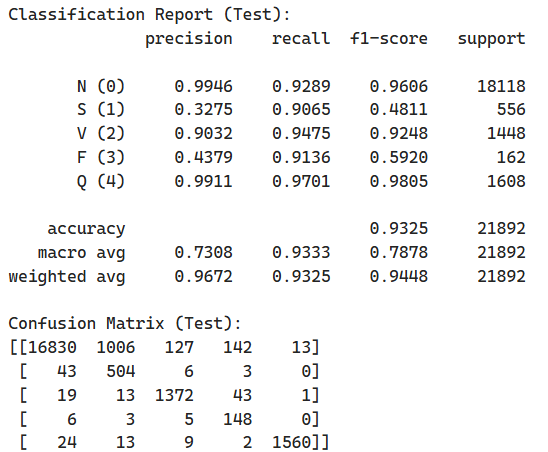

## Case 2: Using Average Pooling function
**Model:** <br>
CNNLSTM(<br>
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool1): **AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))** <br>
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool2): **AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))** <br>
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)<br>
  (dropout): Dropout(p=0.5, inplace=False) <br>
  (fc): Linear(in_features=128, out_features=5, bias=True)<br>
)<br>

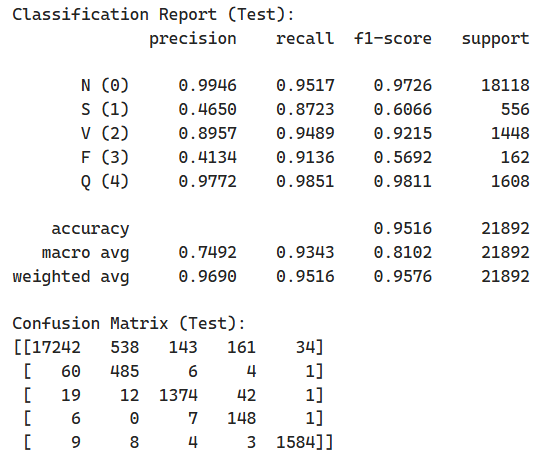

## Case 3: Using Adaptive Max Pooling function
**Model:** <br>
CNNLSTM(<br>
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool1): **AdaptiveMaxPool1d(output_size=50)** <br>
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool2): **AdaptiveMaxPool1d(output_size=50)** <br>
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)<br>
  (dropout): Dropout(p=0.5, inplace=False)<br>
  (fc): Linear(in_features=128, out_features=5, bias=True)<br>
)<br>

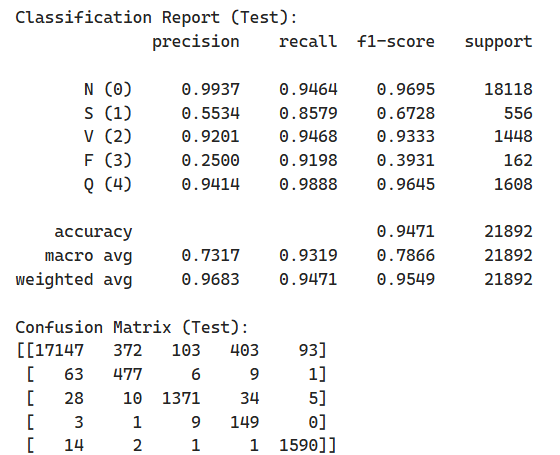


## Case 4: Using Adaptive Average Max pooling function
**Model:** <br>
CNNLSTM(<br>
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool1): **AdaptiveAvgPool1d(output_size=50)** <br>
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))<br>
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
  (pool2): **AdaptiveAvgPool1d(output_size=50)** <br>
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True) <br>
  (dropout): Dropout(p=0.5, inplace=False)<br>
  (fc): Linear(in_features=128, out_features=5, bias=True)<br>
)

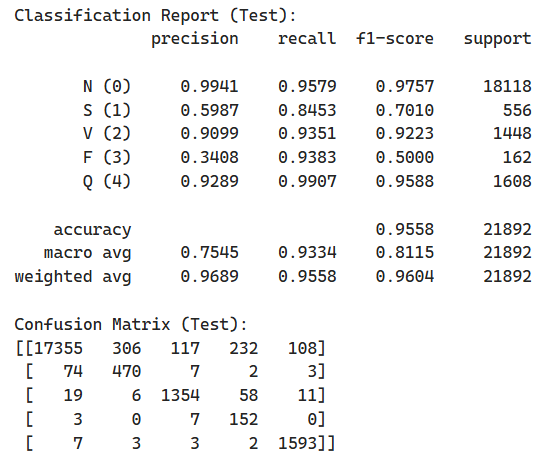


# Conclusion: Effect of Pooling Functions on CNN–LSTM ECG Classification


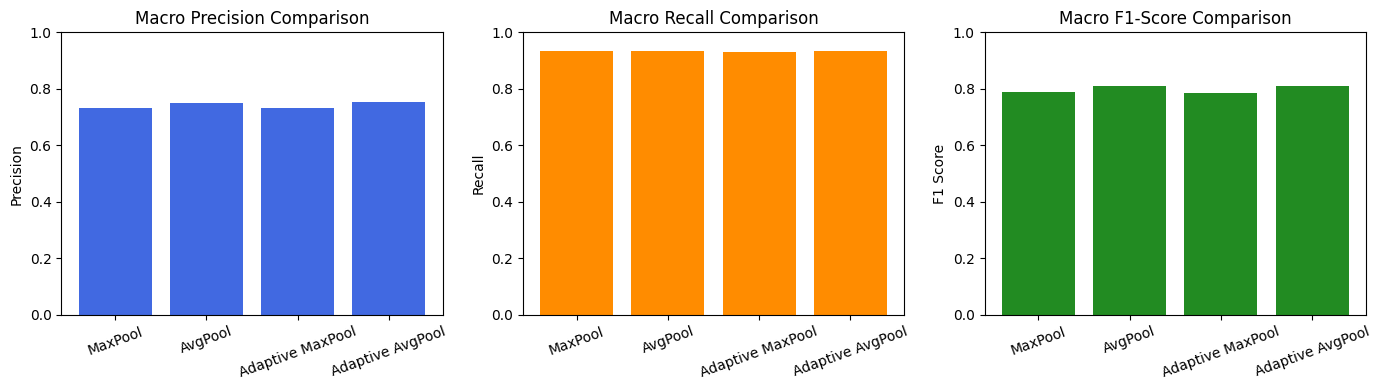


Our experiments show that the pooling function has a significant impact on model performance:

- **Max Pooling** achieved high recall for minority arrhythmia classes but suffered from very poor precision, leading to excessive false positives.
- **Average Pooling** provided a more stable representation of ECG morphology, improving overall accuracy and significantly boosting macro F1-score.
- **Adaptive Max Pooling** offered high sensitivity but again introduced instability by over-amplifying peaks, resulting in lower precision.
- **Adaptive Average Pooling** delivered the best performance across all metrics, achieving the highest accuracy (0.9558) and the highest macro F1-score (0.8115). This method produces fixed-length representations while smoothing local signal variations, allowing the LSTM to learn more consistent temporal features.

**Overall, Adaptive Average Pooling is the most effective pooling strategy for ECG beat classification, providing the best tradeoff between precision, recall, robustness, and generalization.**

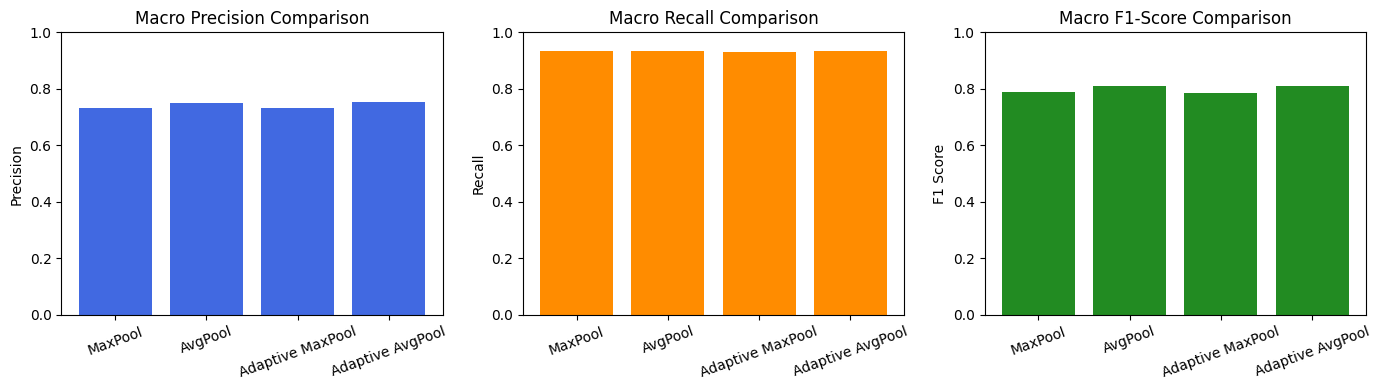

------------------------------------------------------------------------------------

# Visualizing Predictions - CNN + LSTM Hybrid Model using Adaptive Average Pooling

In [13]:

N = 10  # number of predictions to print

label_map = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}


In [14]:

print("\n🔍 Predictions for Each Class:\n")

for class_id in range(5):
    # find all indices where actual label == class_id
    indices = np.where(all_labels == class_id)[0]

    print(f"\nClass {label_map[class_id]} ({class_id}) — showing up to 10 samples:")
    
    # if class is rare, you may not have 10 examples
    num_samples = min(N, len(indices))

    for i in range(num_samples):
        idx = indices[i]
        actual = all_labels[idx]
        pred = all_preds[idx]
        print(f"   Index {idx}: Actual = {label_map[actual]} ({actual}), Predicted = {label_map[pred]} ({pred})")



🔍 Predictions for Each Class:


Class N (0) — showing up to 10 samples:
   Index 0: Actual = N (0), Predicted = N (0)
   Index 1: Actual = N (0), Predicted = Q (4)
   Index 2: Actual = N (0), Predicted = N (0)
   Index 3: Actual = N (0), Predicted = N (0)
   Index 4: Actual = N (0), Predicted = N (0)
   Index 5: Actual = N (0), Predicted = N (0)
   Index 6: Actual = N (0), Predicted = N (0)
   Index 7: Actual = N (0), Predicted = N (0)
   Index 8: Actual = N (0), Predicted = N (0)
   Index 9: Actual = N (0), Predicted = N (0)

Class S (1) — showing up to 10 samples:
   Index 18118: Actual = S (1), Predicted = F (3)
   Index 18119: Actual = S (1), Predicted = S (1)
   Index 18120: Actual = S (1), Predicted = S (1)
   Index 18121: Actual = S (1), Predicted = S (1)
   Index 18122: Actual = S (1), Predicted = S (1)
   Index 18123: Actual = S (1), Predicted = S (1)
   Index 18124: Actual = S (1), Predicted = S (1)
   Index 18125: Actual = S (1), Predicted = S (1)
   Index 18126: Actual = S

In [15]:
import matplotlib.pyplot as plt

label_map = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

def plot_ecg(index, X, actual, predicted):
    """
    index: sample index
    X: original test data (numpy array of shape [21892, 187])
    actual: actual label (int)
    predicted: predicted label (int)
    """
    signal = X[index]

    plt.figure(figsize=(10, 3))
    plt.plot(signal, color='black')
    plt.title(
        f"ECG Sample {index} — Actual: {label_map[actual]} ({actual}), Predicted: {label_map[predicted]} ({predicted})",
        fontsize=14
    )
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


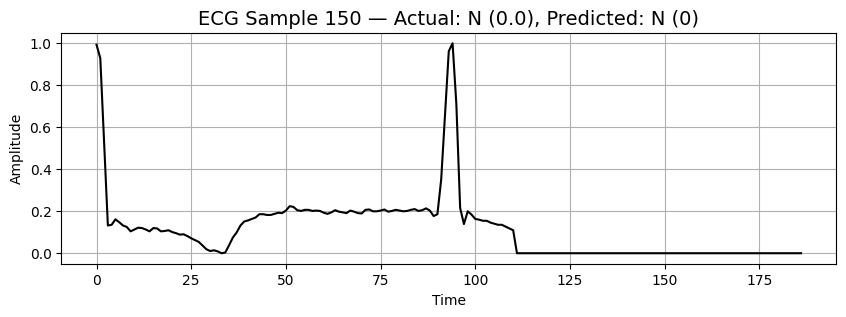

In [16]:
plot_ecg(150, X_test, y_test[150], all_preds[150])


Total misclassifications: 1250


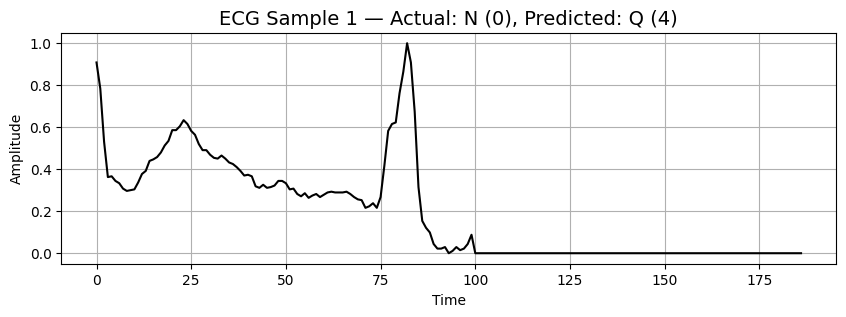

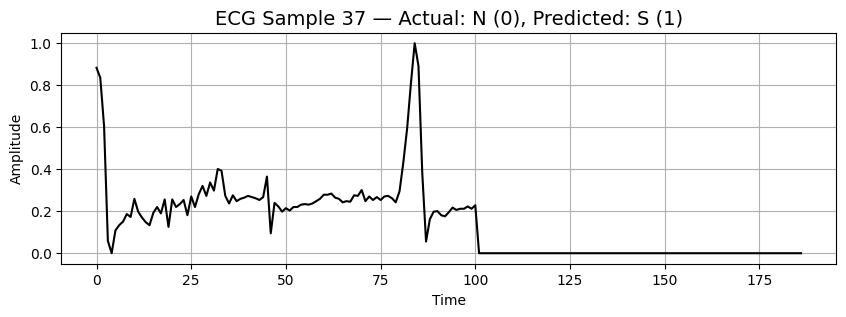

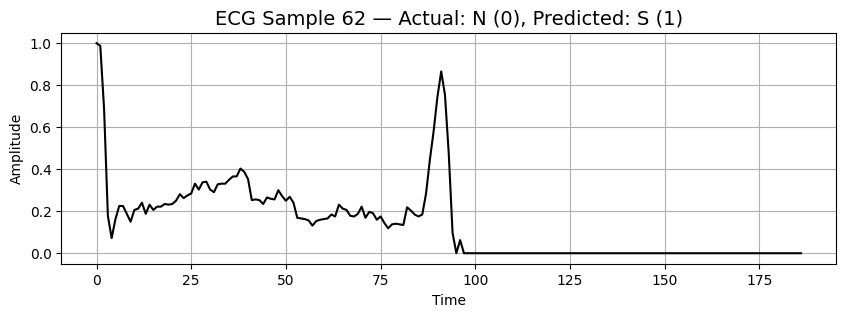

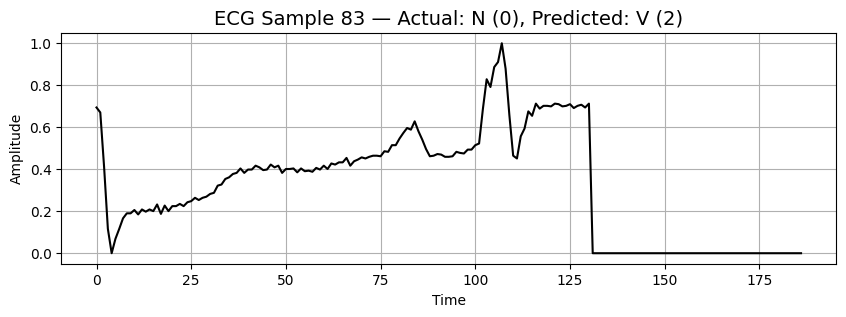

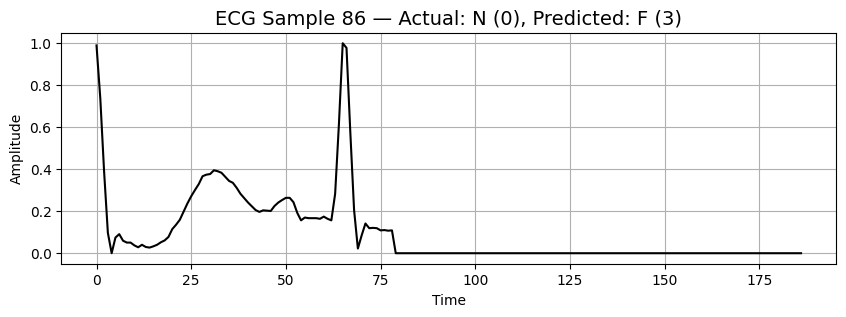

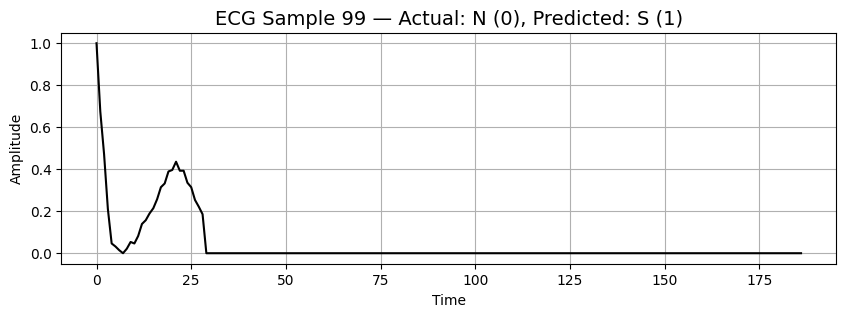

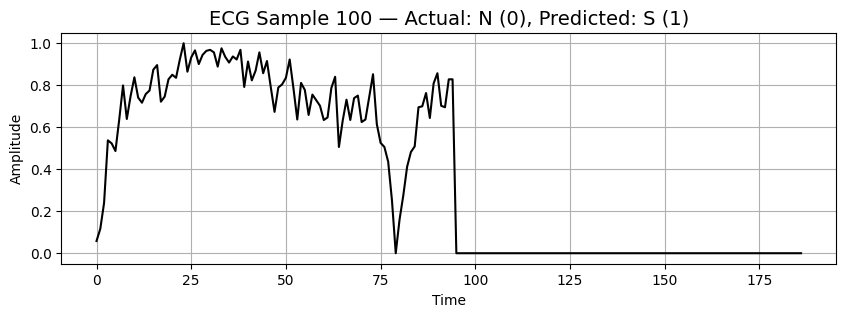

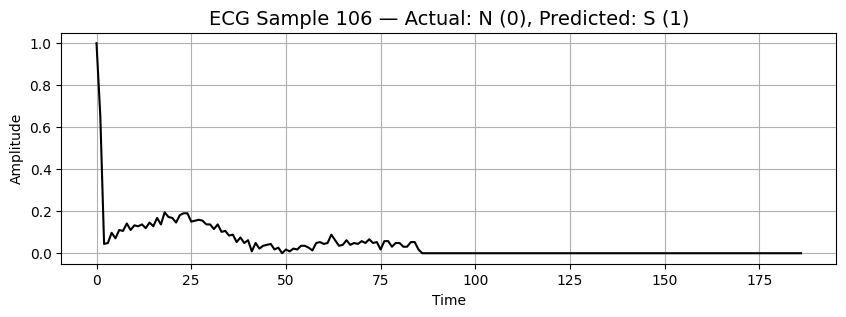

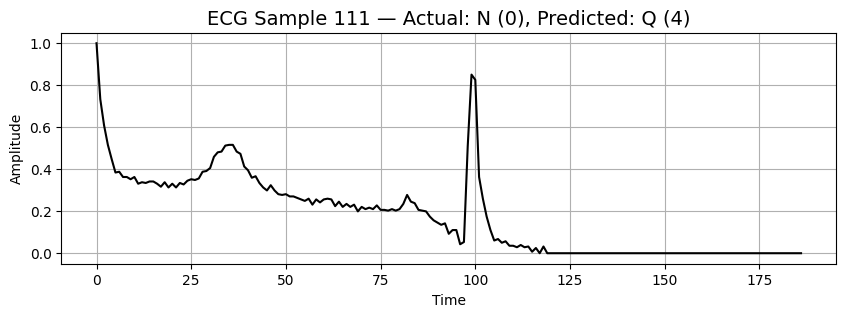

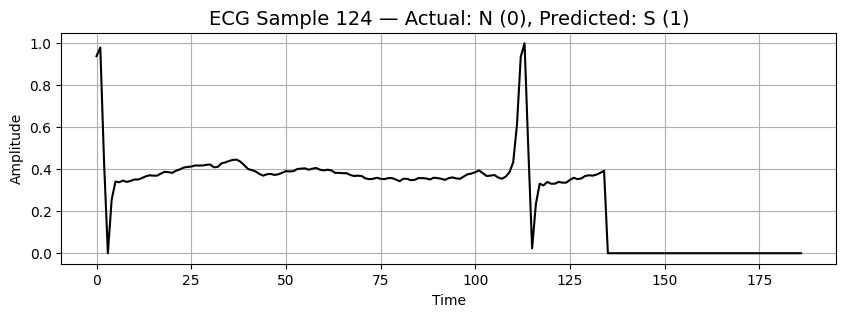

In [17]:
mis_idx = np.where(all_labels != all_preds)[0]

print(f"Total misclassifications: {len(mis_idx)}")

for idx in mis_idx[:10]:  #first 10 misclassification
    plot_ecg(idx, X_test, all_labels[idx], all_preds[idx])


In [18]:
import matplotlib.pyplot as plt
import numpy as np

label_map = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

def misclassification_dashboard(idx, X_test, all_labels, all_preds, all_probs):
    """
    idx: index of misclassified sample
    """
    signal = X_test[idx]
    actual = all_labels[idx]
    predicted = all_preds[idx]
    probs = all_probs[idx]

    confidence = np.max(probs)

    fig = plt.figure(figsize=(15, 5))

    # -------------------------
    # (1) ECG waveform
    # -------------------------
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(signal, color="black")
    ax1.set_title(
        f"ECG #{idx}\nActual: {label_map[actual]} ({actual}) | "
        f"Predicted: {label_map[predicted]} ({predicted})",
        fontsize=13
    )
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True)

    # -------------------------
    # (2) Probability bars
    # -------------------------
    ax2 = plt.subplot(1, 2, 2)
    classes = list(label_map.values())
    colors = ["gray"] * 5
    colors[predicted] = "green"

    ax2.bar(classes, probs, color=colors, alpha=0.8)
    ax2.axvline(x=actual, color="red", linestyle="--", label="Actual Class")

    ax2.set_ylim(0, 1)
    ax2.set_title(f"Predicted Probabilities\nModel Confidence: {confidence:.2f}", fontsize=13)
    ax2.set_ylabel("Probability")
    ax2.legend()

    plt.tight_layout()
    plt.show()


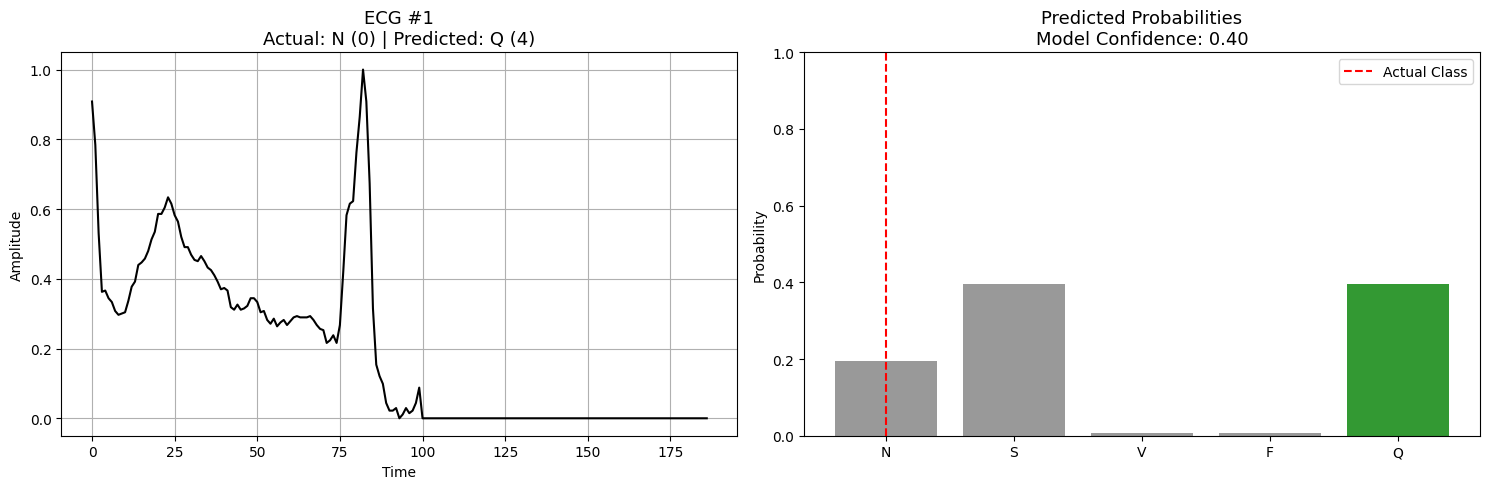

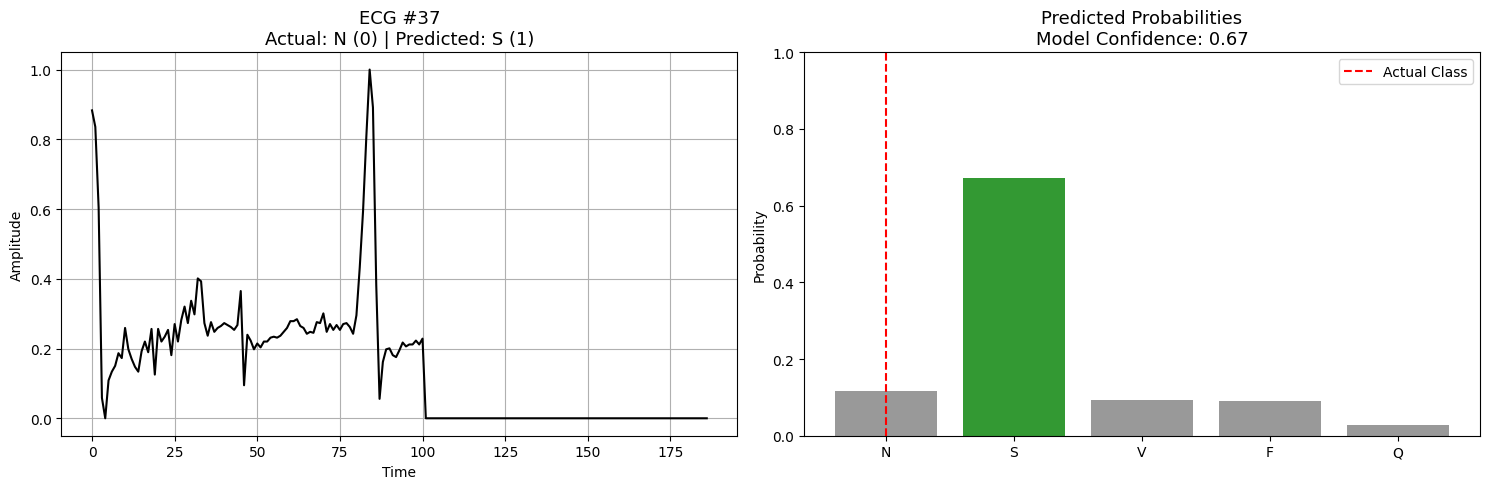

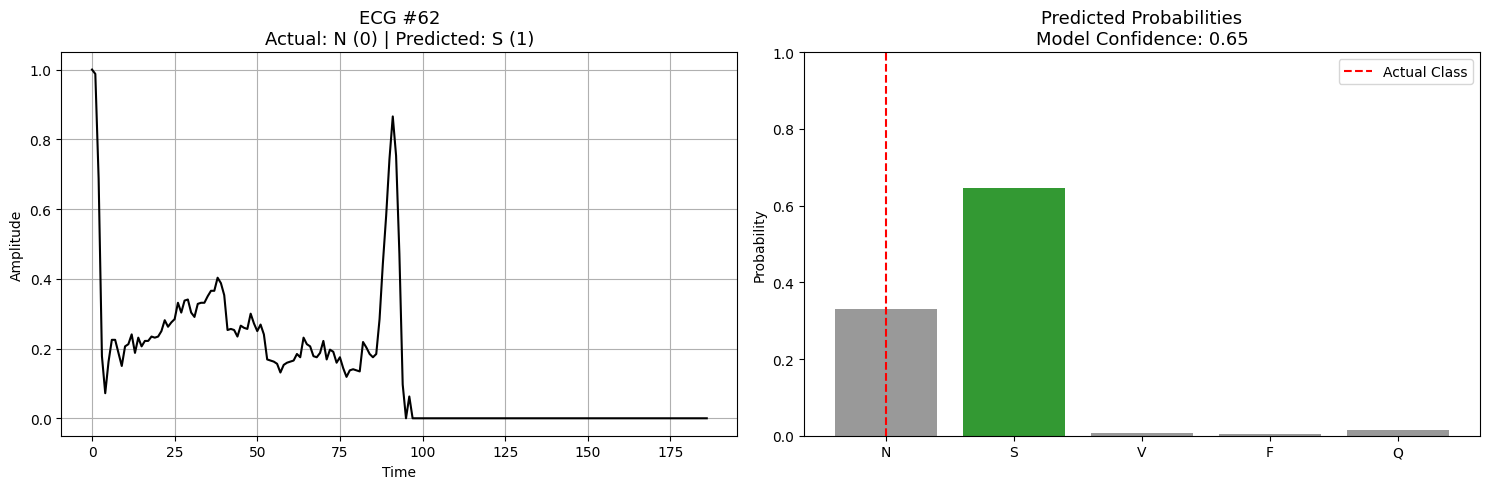

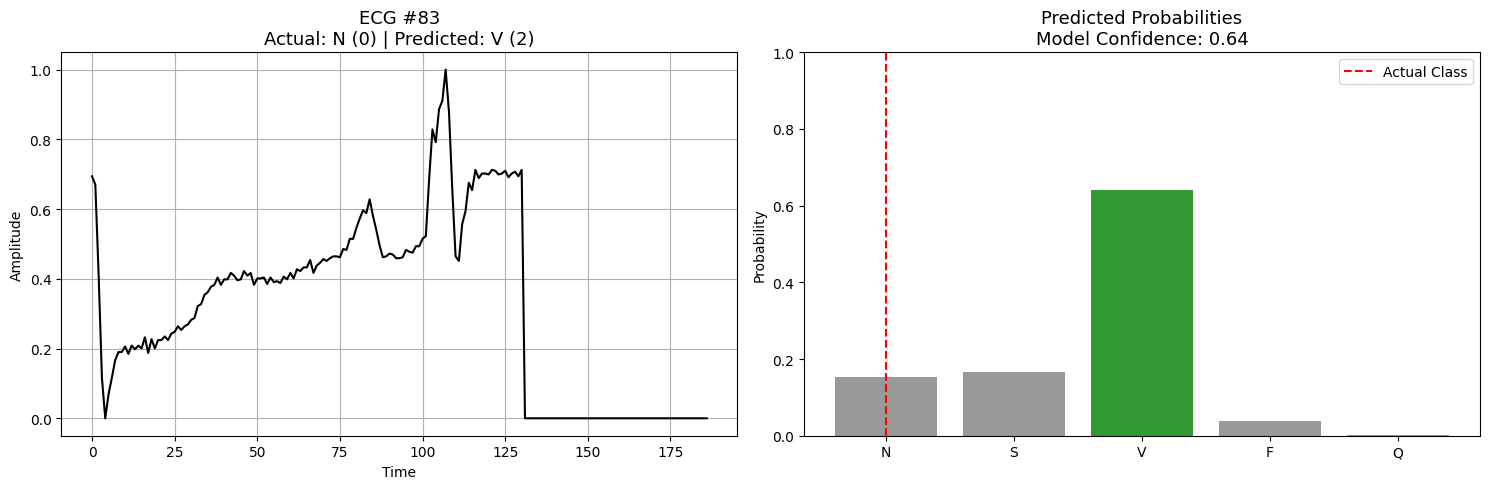

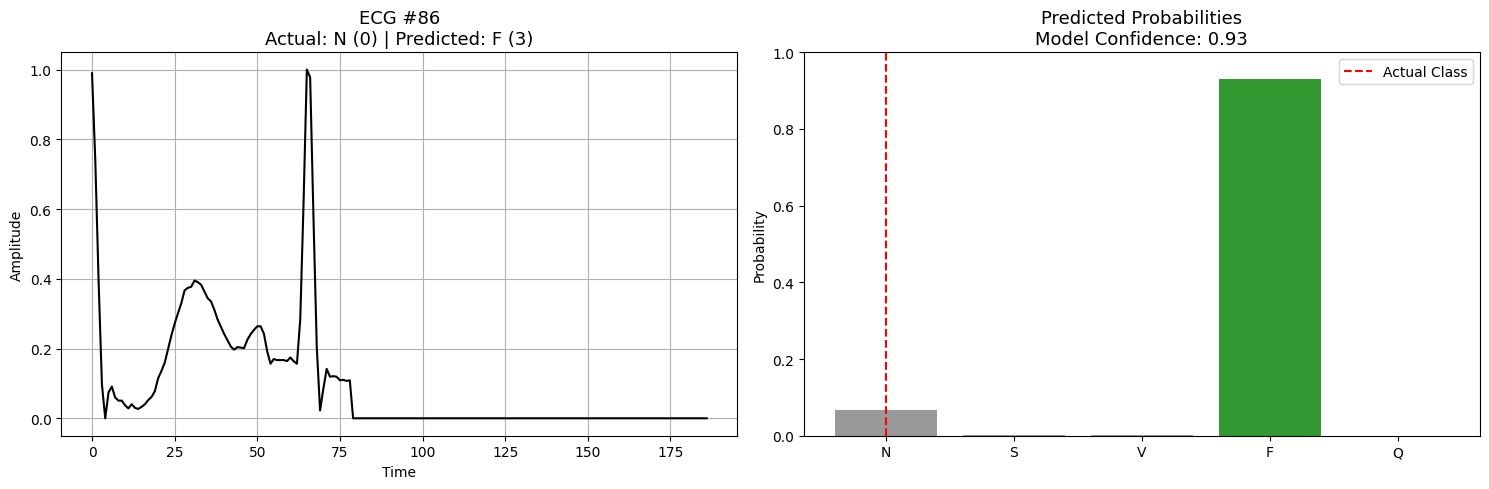

In [19]:
mis_n = mis_idx[ all_labels[mis_idx] == 0 ]

for idx in mis_n[:5]:
    misclassification_dashboard(
        idx, X_test, all_labels, all_preds, all_probs
    )

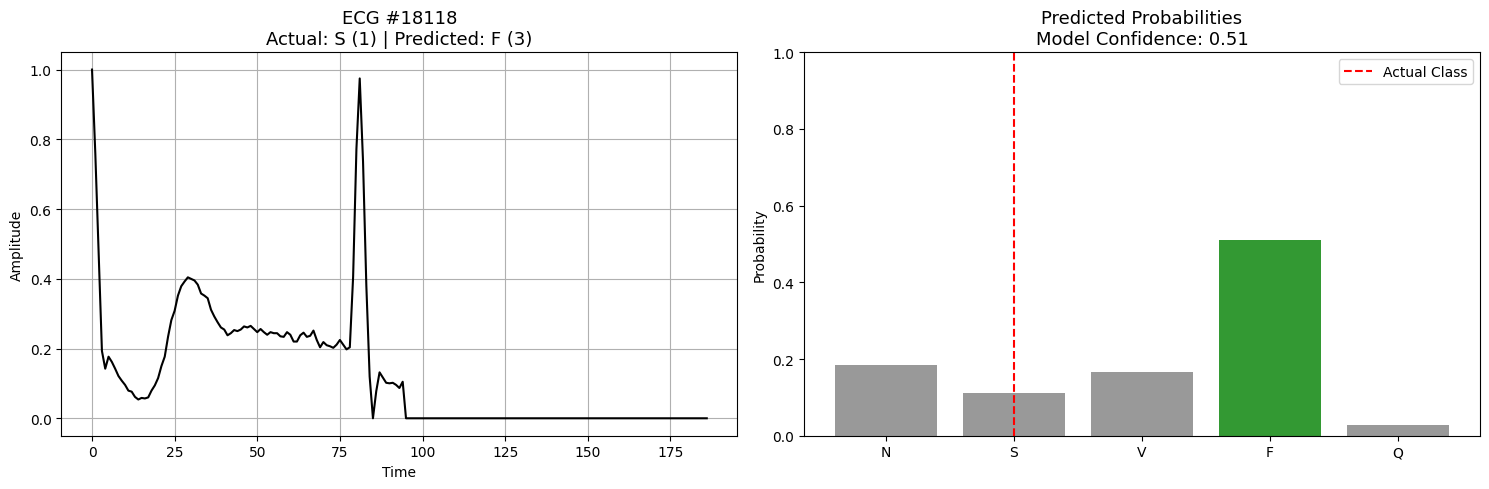

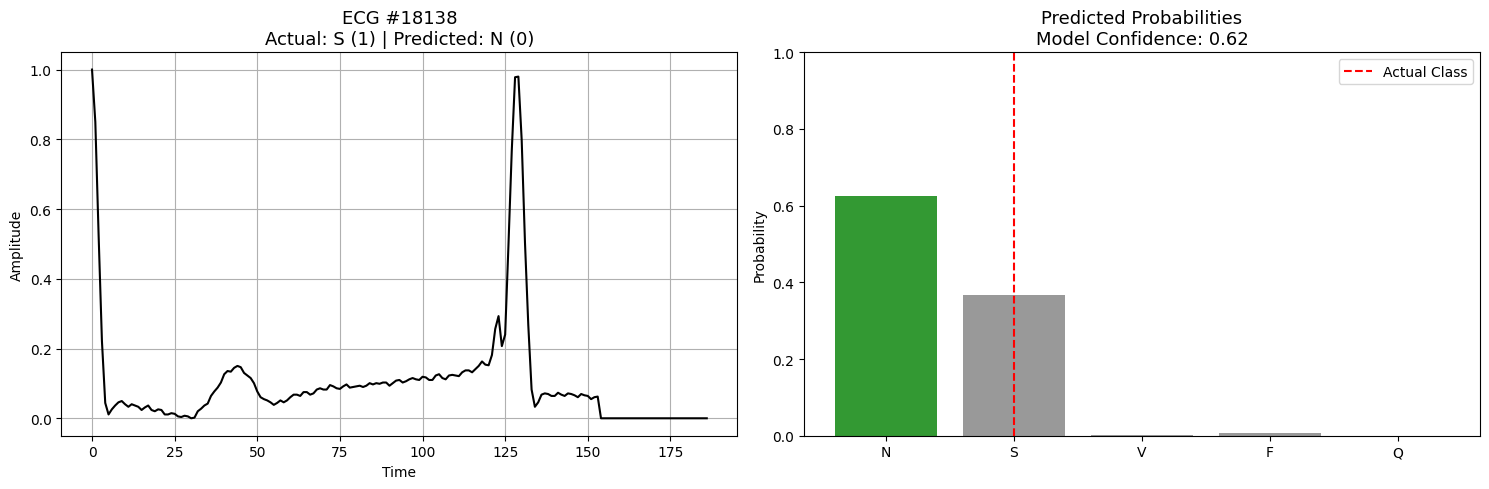

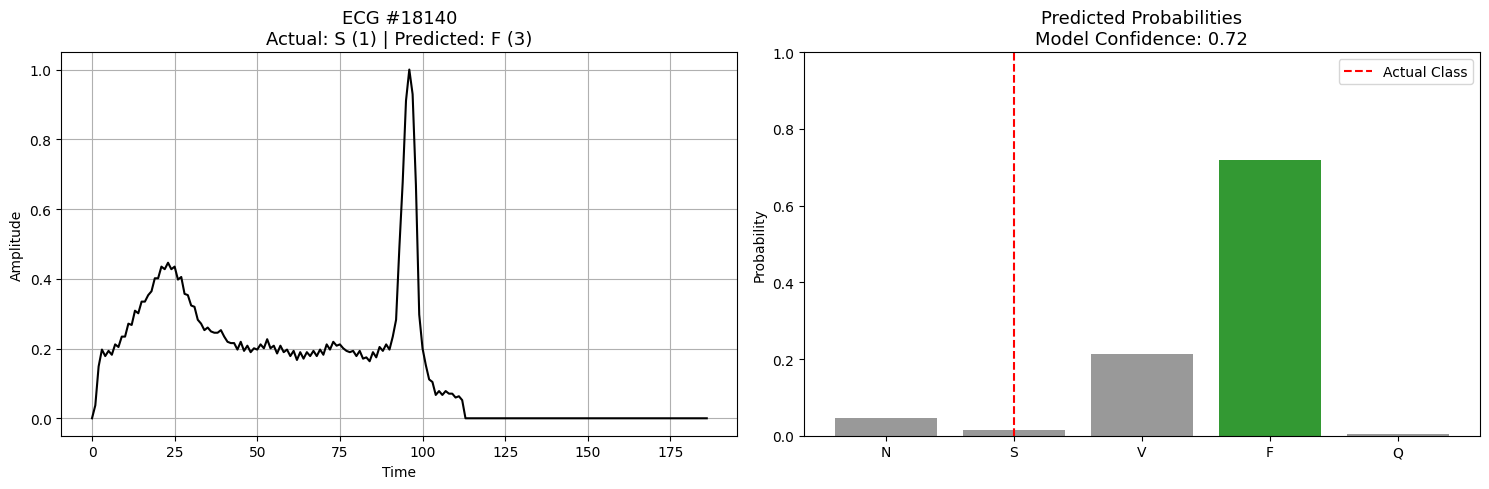

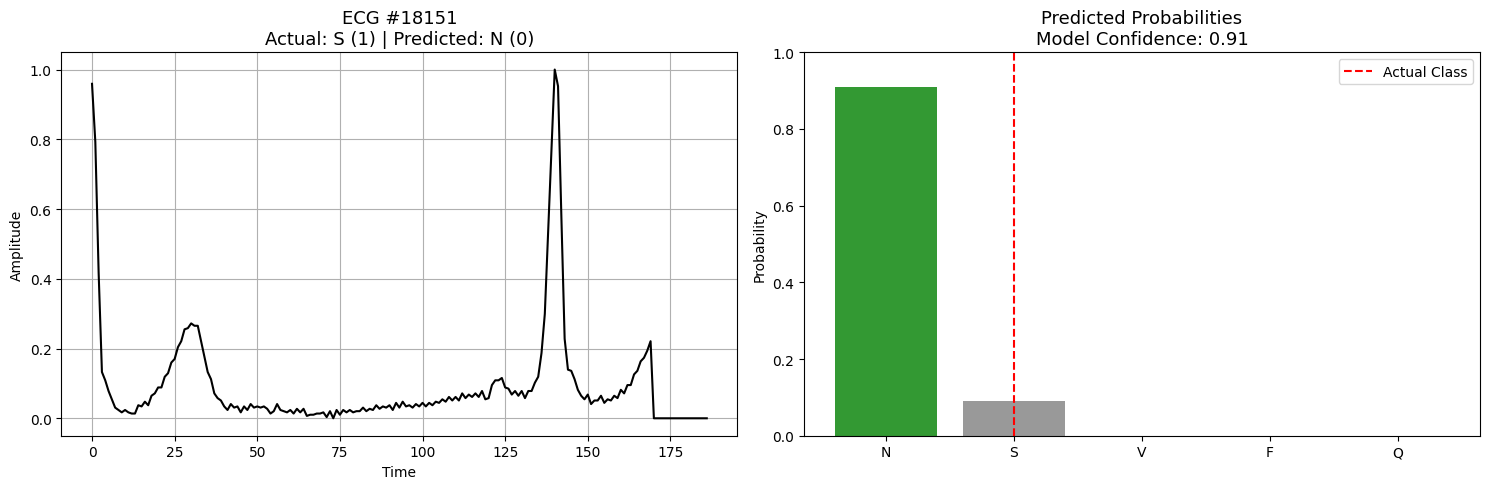

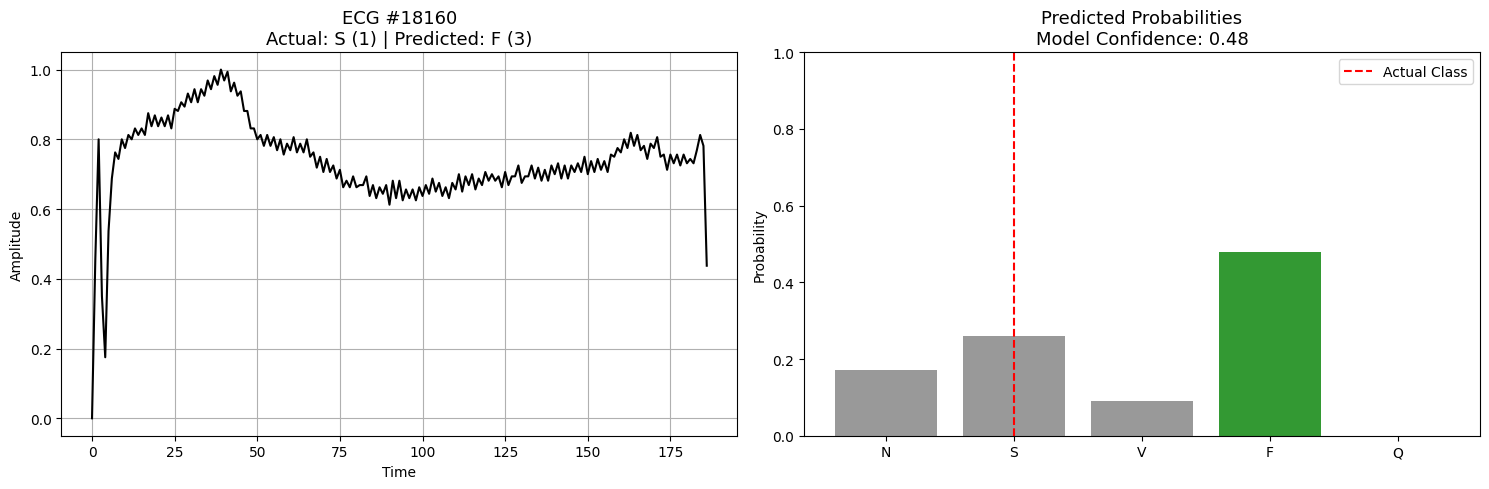

In [20]:
mis_s = mis_idx[ all_labels[mis_idx] == 1 ]

for idx in mis_s[:5]:
    misclassification_dashboard(
        idx, X_test, all_labels, all_preds, all_probs
    )

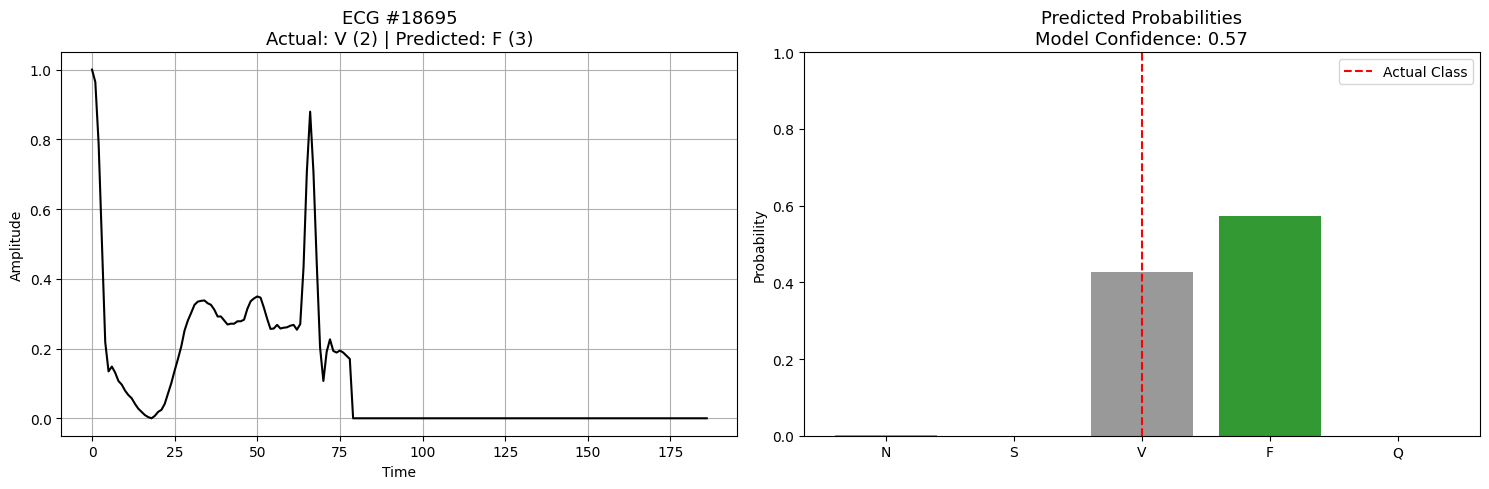

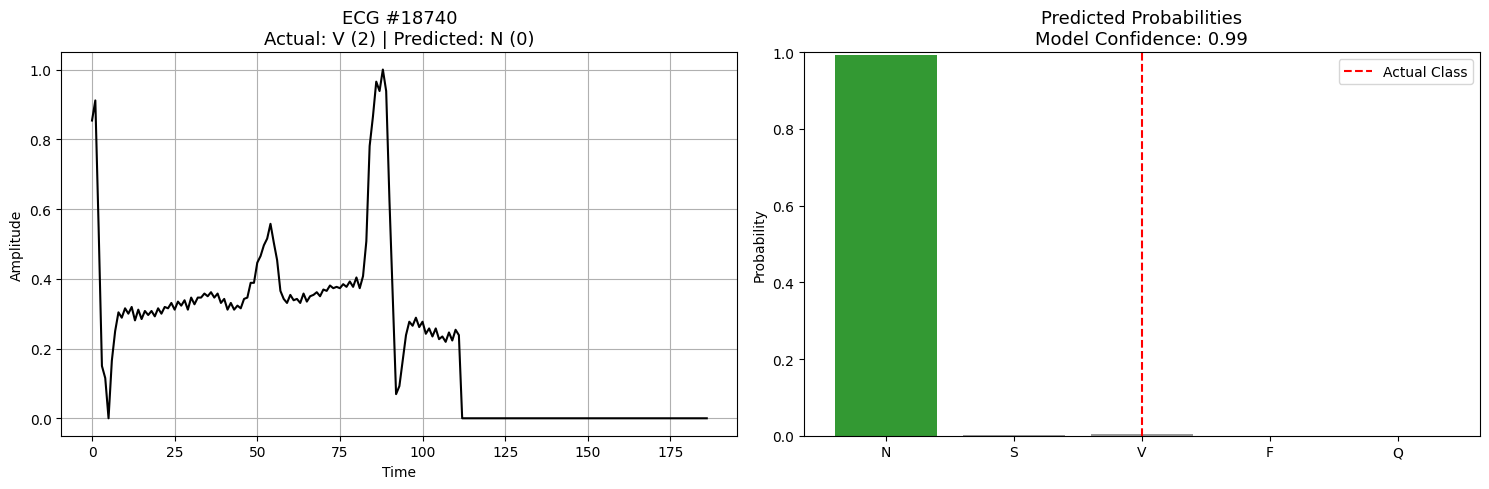

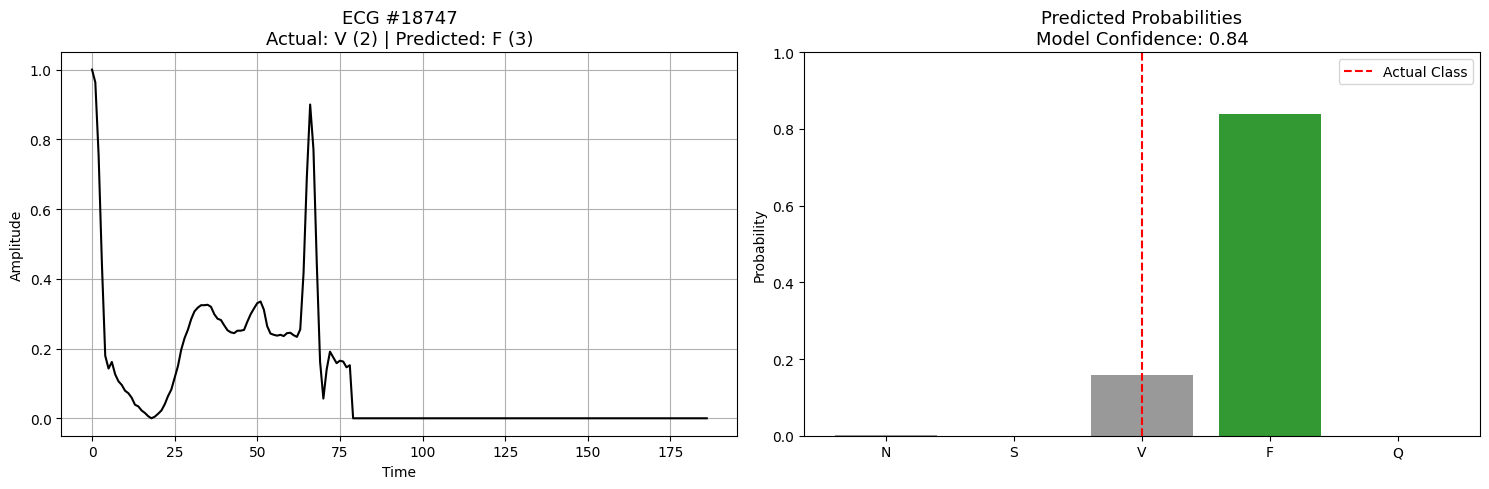

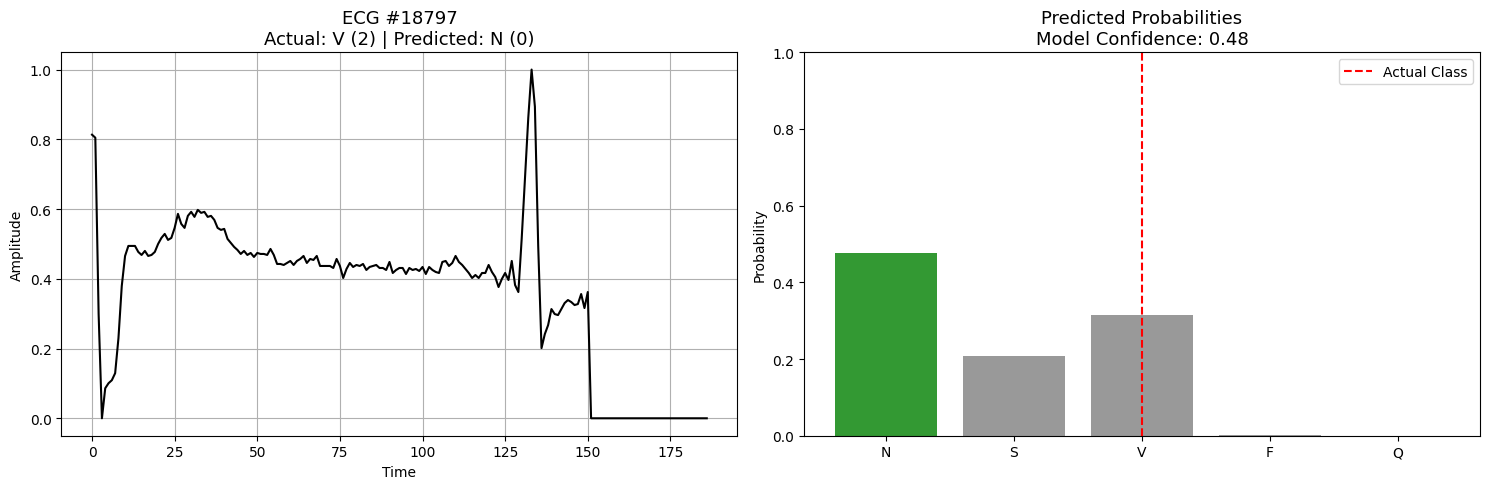

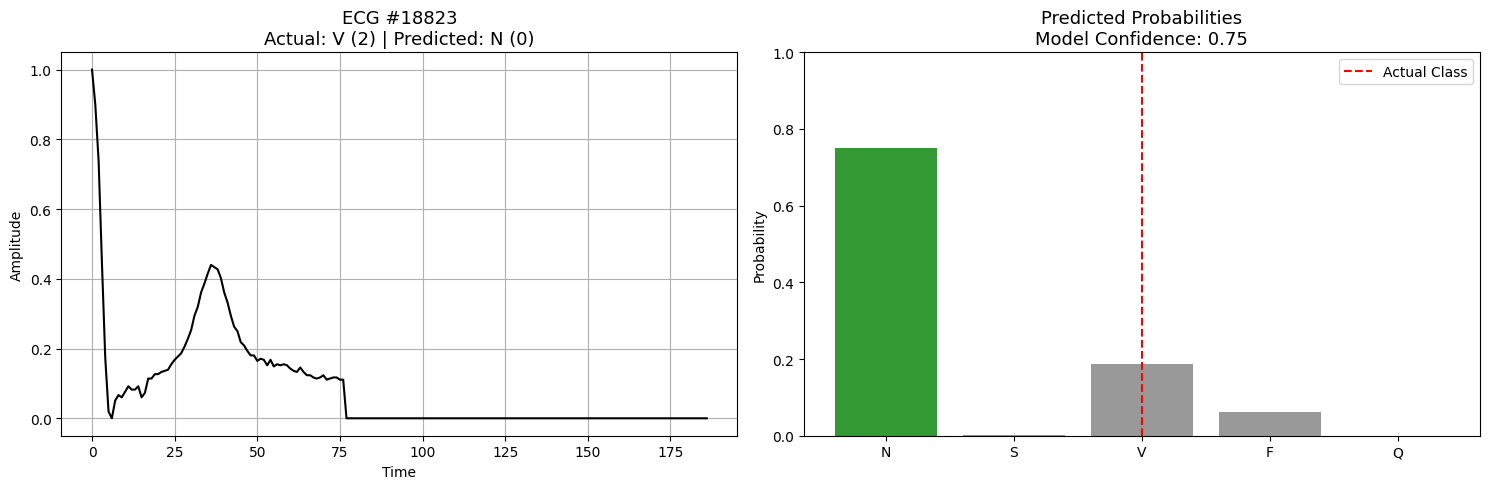

In [21]:
mis_v = mis_idx[ all_labels[mis_idx] == 2 ]

for idx in mis_v[:5]:
    misclassification_dashboard(
        idx, X_test, all_labels, all_preds, all_probs
    )


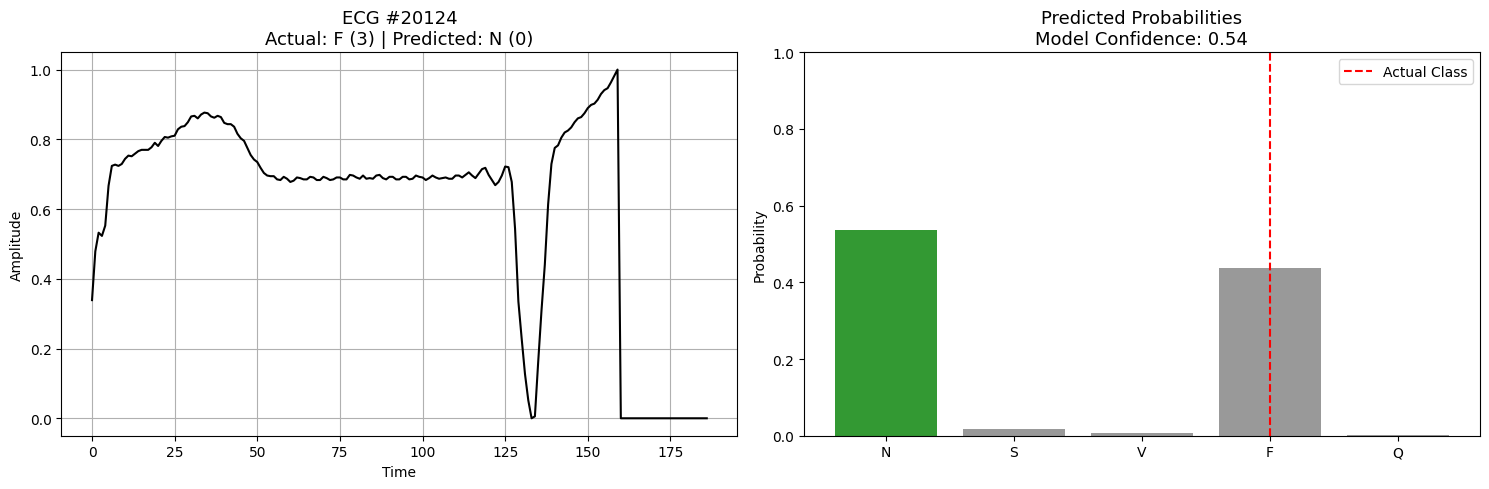

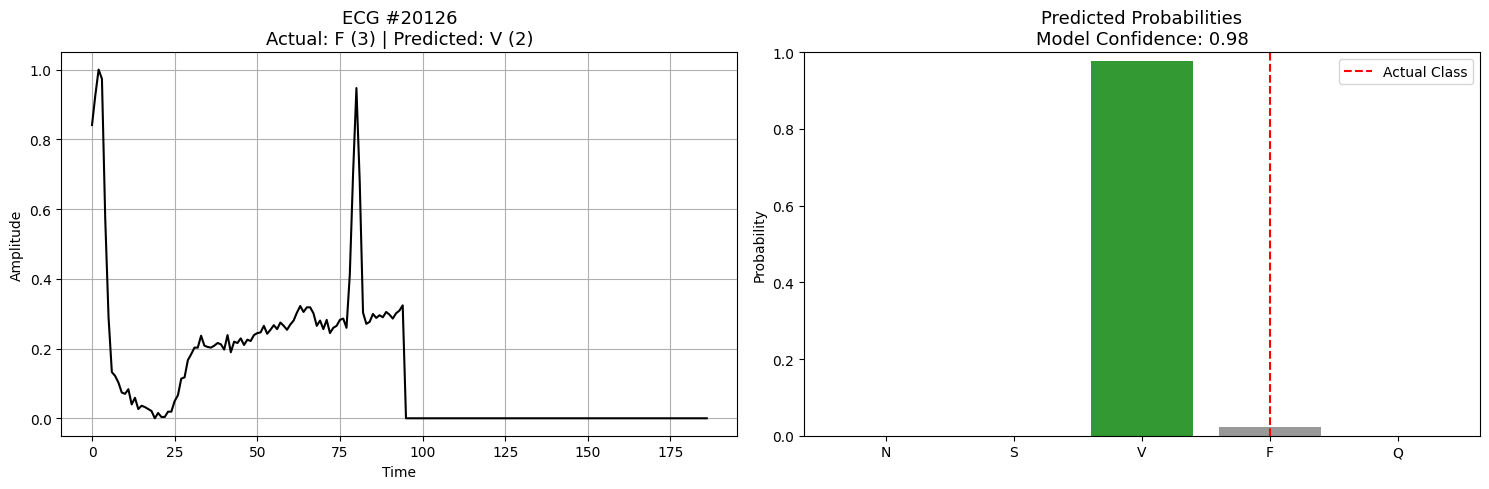

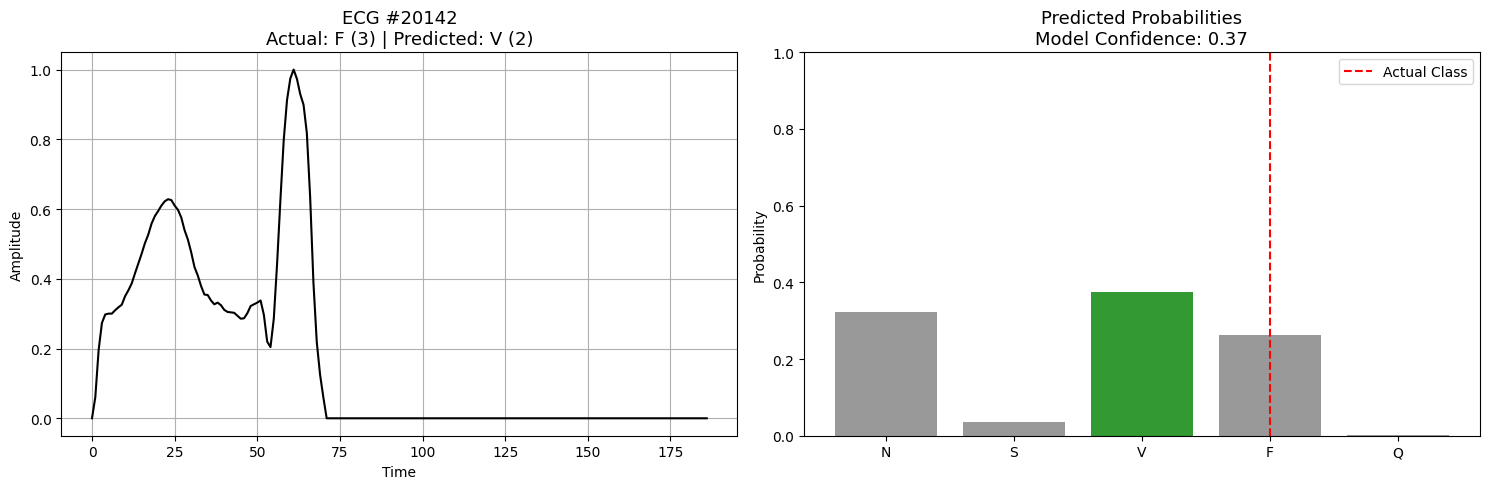

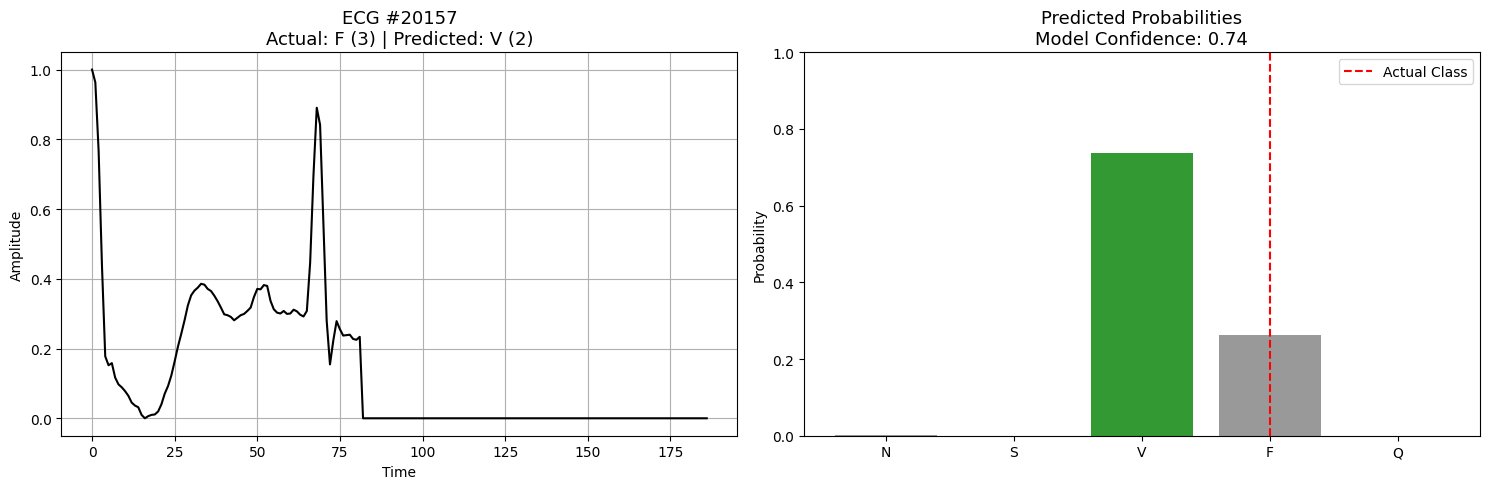

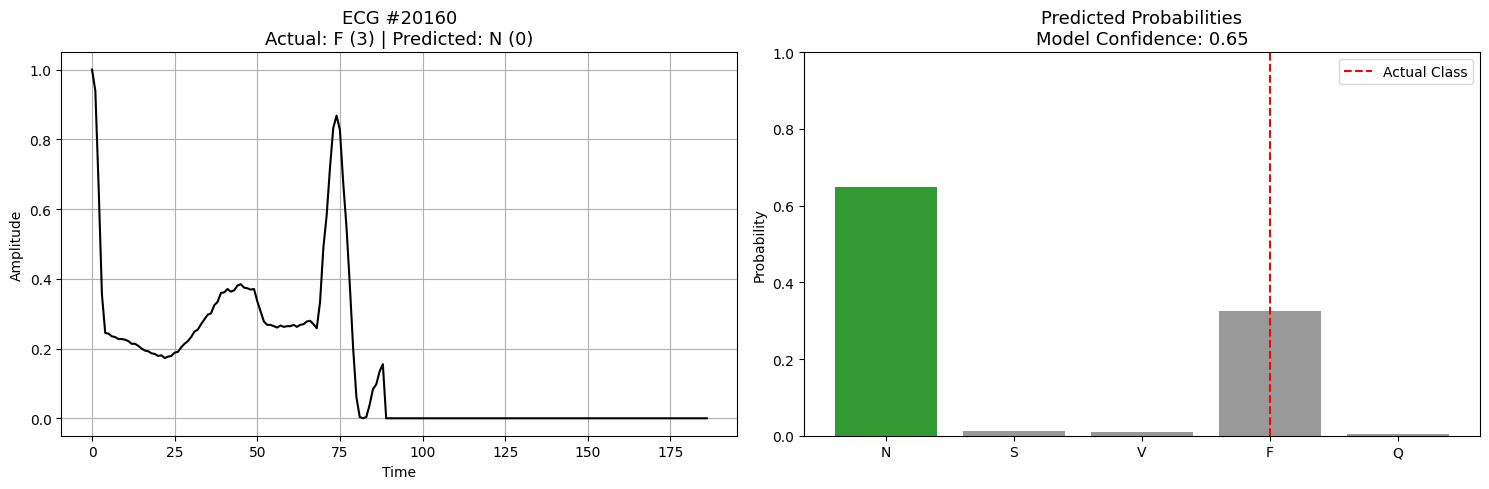

In [22]:
mis_f = mis_idx[ all_labels[mis_idx] == 3 ]

for idx in mis_f[:5]:
    misclassification_dashboard(
        idx, X_test, all_labels, all_preds, all_probs
    )

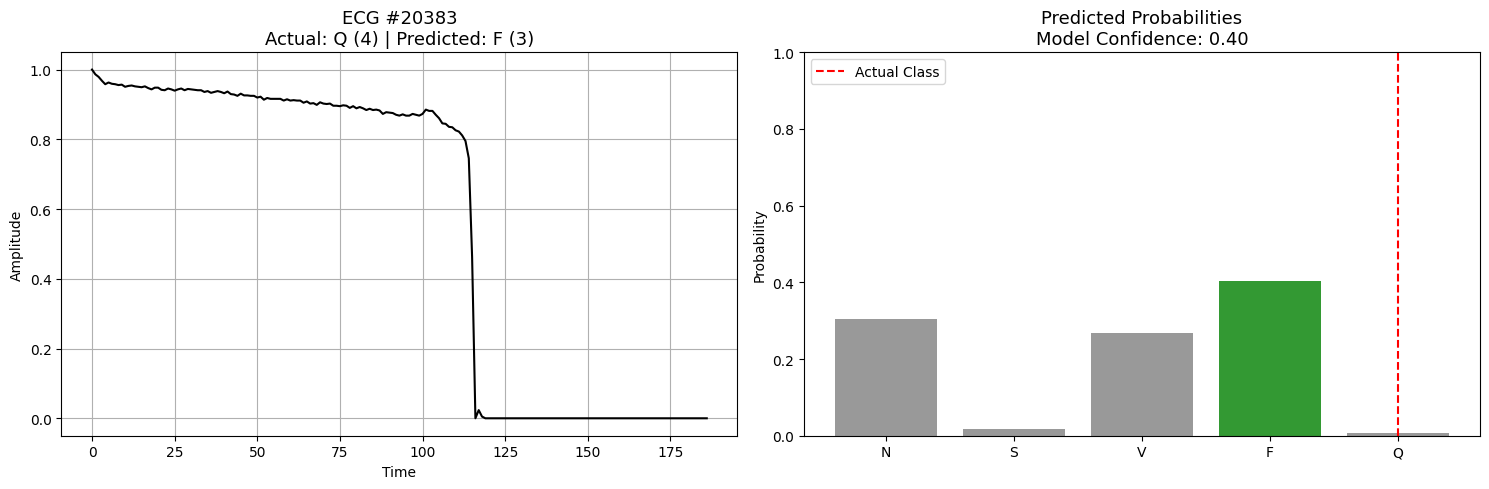

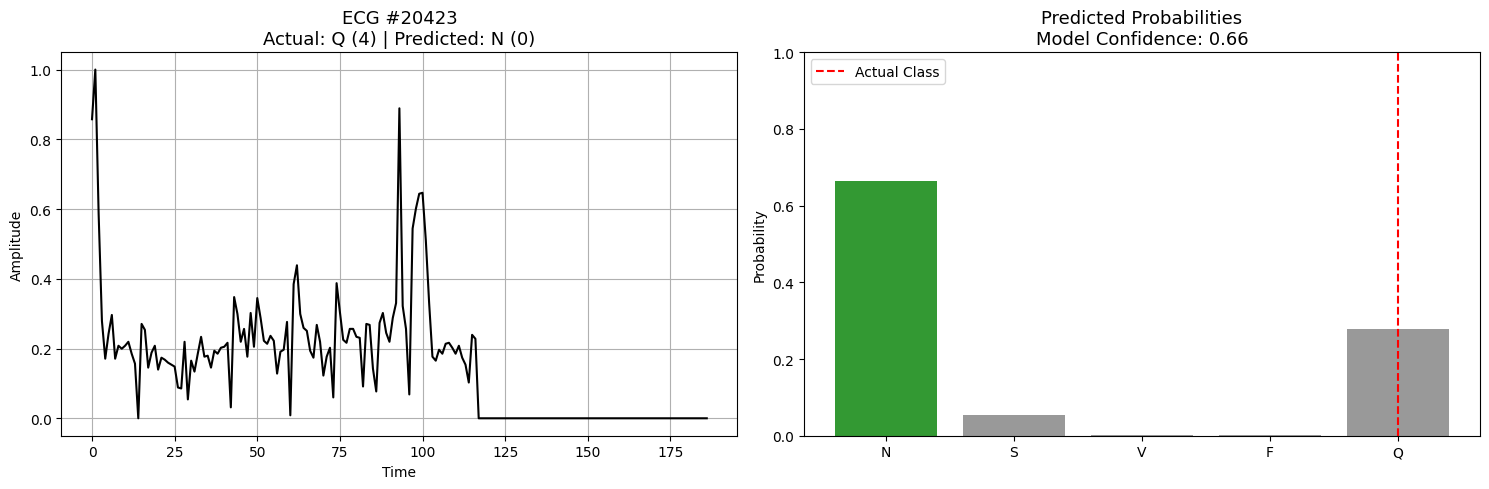

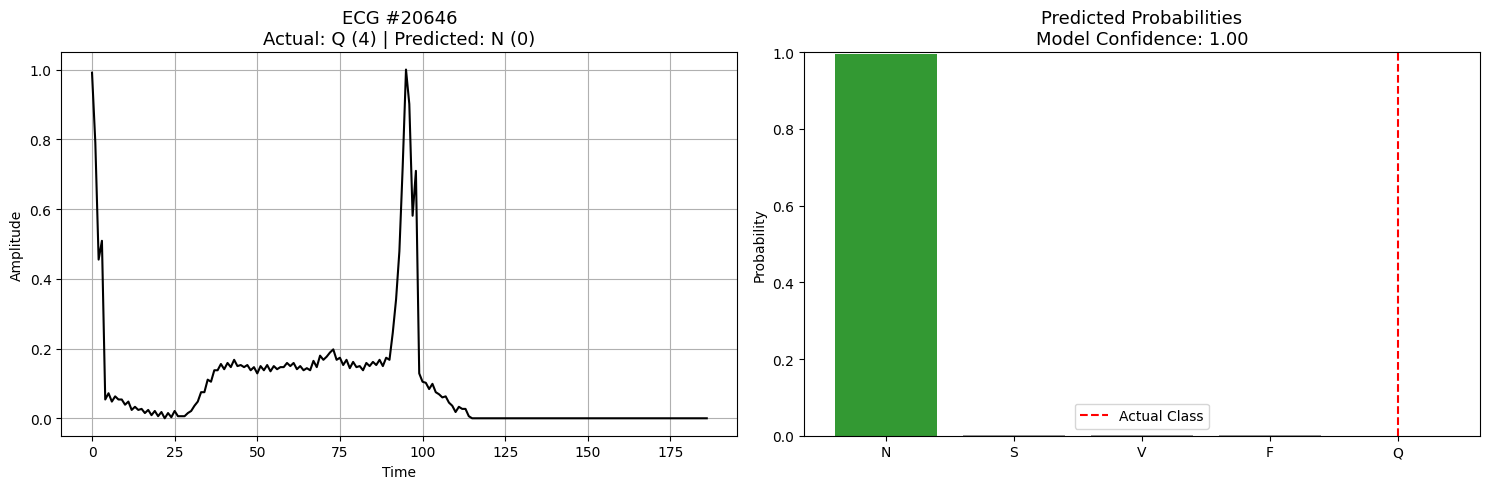

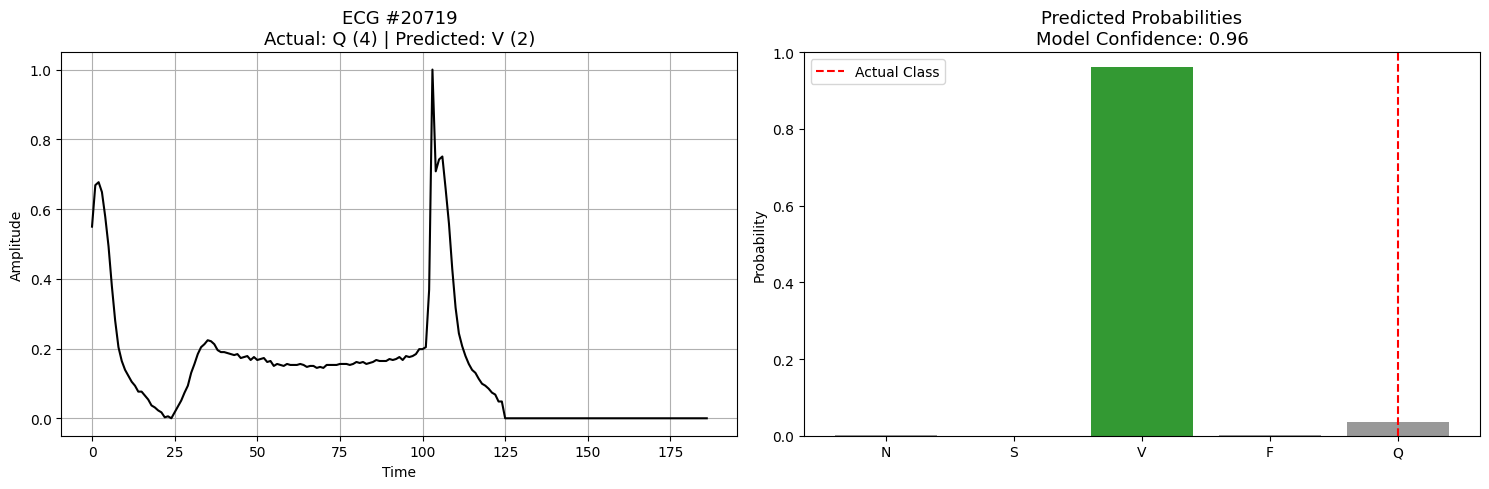

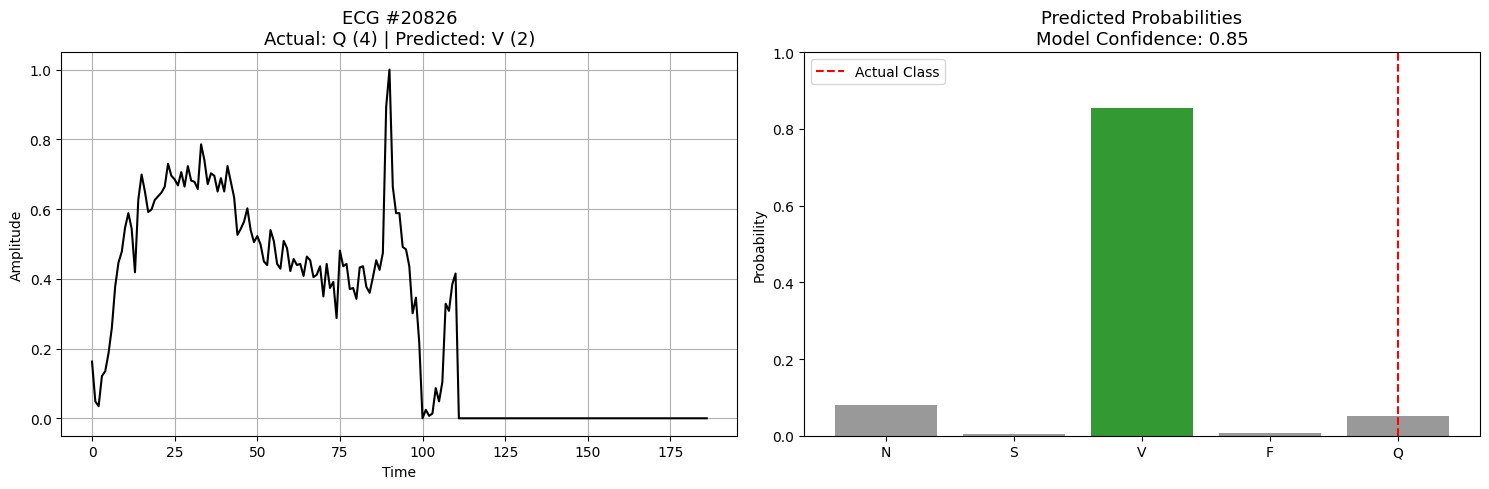

In [23]:
mis_q = mis_idx[ all_labels[mis_idx] == 4 ]

for idx in mis_q[:5]:
    misclassification_dashboard(
        idx, X_test, all_labels, all_preds, all_probs
    )